# HPC- Project Stage 2
## Pranav Rao- 15008121

In [1]:
import time
import numpy as np
import pyopencl as cl
import matplotlib.pyplot as plt
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

In [2]:
# Normally Distributed sigma field
def make_random_sigma(N, mean=2, sd=0.5, seed=0):
    S = np.random.RandomState(seed).normal(mean, sd, (N, N))
    sigma = np.exp(np.negative(S))
    return sigma

In [3]:
def evolve(u):
    """Matrix free opencl implementation of finite difference methods
       to solve the given poisson equation.
       Uses the 5 point stencil to evaluate the sccuessive value of u.
    """
    u = np.ascontiguousarray(u)
    sigma = make_random_sigma(N)
    kernel = """
    __kernel void solve_poisson_equation(__global double *u,
                                         __global double *sigma,
                                         __global double *solution,
                                         __global double *next_u)
    {
        int N = get_global_size(0);
        double h = (double) 1.0/(N+1);
        double dt = 0.5*h*h;

        int i = get_global_id(0);
        int j = get_global_id(1);

        // 5 Point Stencil for u and sigma

        double u_up; double u_down; double u_right; double u_left; double u_centre;
        double sigma_up; double sigma_down; double sigma_right; double sigma_left;
        double sigma_centre;

        if (i == 0) {
            u_up = 0;
            sigma_up = sigma[(i + 1) * N + j];
        } else {
            u_up = u[(i - 1) * N + j];
            sigma_up = sigma[(i - 1) * N + j];
        }

        if(j == 0) {
            u_left = 0;
            sigma_left = sigma[i * N + j + 1];
        }else {
            u_left = u[i * N + j - 1];
            sigma_left = sigma[i * N + j - 1];
        }

        if(j == (N - 1)) {
            u_right = 0;
            sigma_right = sigma[i * N + j - 1];
        }else {
            u_right = u[i * N + j + 1];
            sigma_right = sigma[i * N + j + 1];
        }

        if(i == (N - 1)){
            u_down = 0;
            sigma_down = sigma[(i - 1) * N + j];
        }else {
            u_down = u[(i + 1) * N + j];
            sigma_down = sigma[(i + 1) * N + j];
        }

        u_centre = u[i * N + j];
        sigma_centre = sigma[i * N + j];

        solution[i * N + j] = ((0.5 * (sigma_down + sigma_centre) * (u_down - u_centre)/h -
                                0.5 * (sigma_up + sigma_centre) * (u_centre - u_up)/h)/h +
                               (0.5 * (sigma_right + sigma_centre) * (u_right - u_centre)/h -
                                0.5 * (sigma_left + sigma_centre) * (u_centre - u_left)/h)/h);

        next_u[i * N + j] = solution[i * N + j] * dt + u[i * N + j];
    }

    """

    prg = cl.Program(ctx, kernel)
    prg.build()
    poisson_equation_kernel = prg.solve_poisson_equation
    mf = cl.mem_flags
    
    sigma_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=sigma)
    u_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_WRITE, hostbuf=u)
    solution_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, size = N * N * 8)
    next_u_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, size= N * N * 8)

    poisson_equation_kernel(queue, (N, N), (1, 1), u_buffer, sigma_buffer, solution_buffer, next_u_buffer)
    
    next_u, _ = cl.enqueue_map_buffer(queue, next_u_buffer, cl.map_flags.READ, 0, (N*N,), np.double)

    queue.finish()

    return next_u


In [4]:
def make_inital_u(N, implementation='square'):
    """ Function that returns the initial u
        for N number of spatial descretisation 
        points. 
        
        String implementation: square or circle
            defines the shape of the initial weight.
    """
    u0 = np.ones((N,N))
    
    # Square weight
    if(implementation == 'square'):
        for i in range(0,int(N/3)):
            u0[:, N-i-1] = 0
            u0[:, i] = 0
            u0[N-i-1, :] = 0
            u0[i, :] = 0
    # Cirlce weight
    else:
        for i in range(0,N):
            for j in range(0,N):
                if ((i-N/2)**2 + (j-N/2)**2) >= N:
                    u0[i,j] = 0
                    
    return u0

149.0


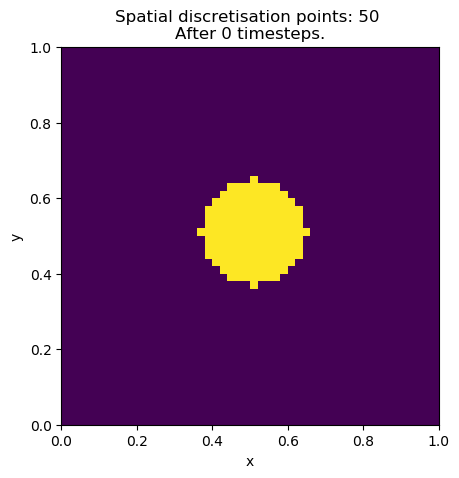

In [5]:
t_max = 101
N = 50
u0 = make_inital_u(N, 'circle')
xyt = np.zeros((N, N, t_max))
for t_id in range(0, t_max):
    if (t_id == 0):
        xyt[:, :, t_id] = u0
    else:
        xyt[:, :, t_id] = evolve(xyt[:, :, t_id - 1]).reshape(N,N)
        
    if t_id % 250 == 0:
        print(xyt[:,:,t_id].sum())
        plt.figure(dpi=100,figsize=(5,5))
        plt.imshow(xyt[:,:,t_id],extent=[0,1,0,1],origin="lower")
        plt.title("Spatial discretisation points: {0} \nAfter {1} timesteps.".format(N, t_id))
        plt.xlabel("x")
        plt.ylabel("y")


324.0
323.9999999999951
323.9999990557229
323.9998701690835
323.99783018928827


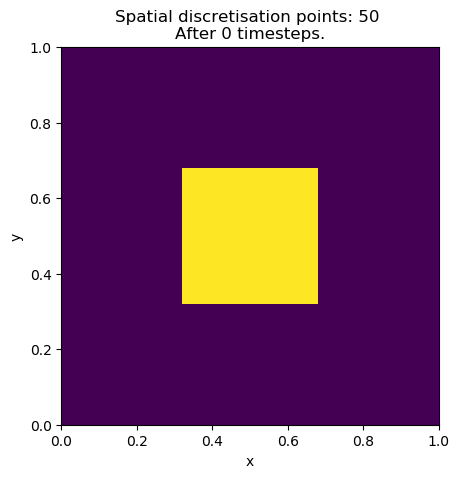

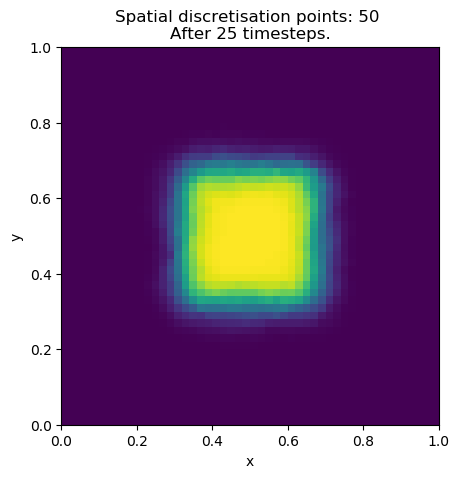

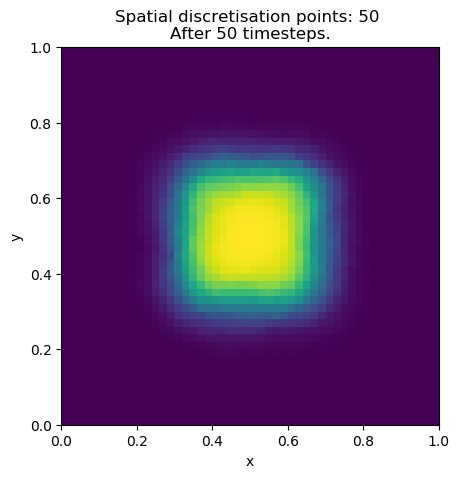

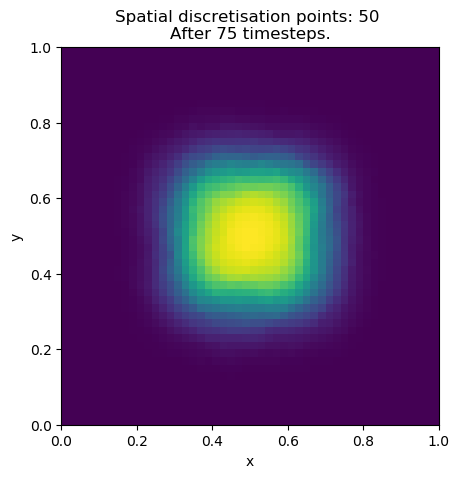

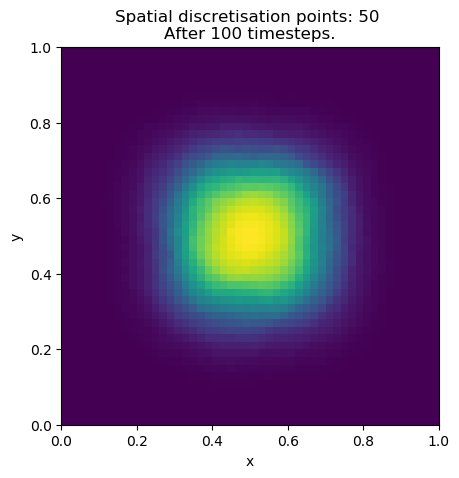

In [6]:
t_max = 101
N = 50
u0 = make_inital_u(N, 'square')
xyt = np.zeros((N, N, t_max))
for t_id in range(0, t_max):
    if (t_id == 0):
        xyt[:, :, t_id] = u0
    else:
        xyt[:, :, t_id] = evolve(xyt[:, :, t_id - 1]).reshape(N,N)
        
    if t_id % 25 == 0:
        print(xyt[:,:,t_id].sum())
        plt.figure(dpi=100,figsize=(5,5))
        plt.imshow(xyt[:,:,t_id],extent=[0,1,0,1],origin="lower")
        plt.title("Spatial discretisation points: {0} \nAfter {1} timesteps.".format(N, t_id))
        plt.xlabel("x")
        plt.ylabel("y")


In [7]:
class Timer:

    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

In [8]:
N = 50
u0 = make_inital_u(N)
with Timer() as t:
    for n in range(0,10):
        u0 = evolve(u0)
print("Time taken for 10 iterations: {} sec, with N of {}".format(t.interval,N))

Time taken for 10 iterations: 0.06655001640319824 sec, with N of 50
